## I. Setup & Data Loading

In [1]:
# Install missing packages (run in notebook)
%pip install shap lightgbm sklearn
# Pin SciPy to a version compatible with installed SHAP to avoid ImportError for internal utilities
# Also pin SHAP to a stable release known to work with SciPy 1.10.x
%pip install --upgrade "scipy==1.10.1" "shap==0.41.0" --quiet

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: shap in c:\users\vtc\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages (0.50.0)
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'



  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for shap (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [117 lines of output]
      The nvcc binary could not be located in your $PATH. Either  add it to your path, or set $CUDAHOME to enable CUDA
      Error building cuda module: TypeError('cannot unpack non-iterable NoneType object')
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-311\shap
      copying shap\datasets.py -> build\lib.win-amd64-cpython-311\shap
      copying shap\links.py -> build\lib.win-amd64-cpython-311\shap
      copying shap\_explanation.py -> build\lib.win-amd64-cpython-311\shap
      copying shap\_serializable.py -> build\lib.win-amd64-cpython-311\shap
      copying shap\__init__.py -> build\lib.win-amd64-cpython-311\shap
      creating build\lib.win-amd64-cpython-311\shap\explainers
      copying shap\explainers\mimic.py -> build\lib.win-amd64-cpython-311\shap\explainers

In [ ]:
# Paths
BASE_DIR = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_DIR = BASE_DIR / "data/features"
MODEL_DIR = BASE_DIR / "models/pipeline"
METRICS_DIR = BASE_DIR / "models/metrics/pipeline"
PRED_DIR = BASE_DIR / "predictions"

MODEL_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)
PRED_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")

In [ ]:
# Load data
cwd = Path.cwd()
BASE_DIR = cwd.parent if cwd.name == 'notebooks' else cwd
DATA_DIR = BASE_DIR.parent / "supplement_data/features"
MODEL_DIR = BASE_DIR / "saved_models/pipeline"
METRICS_DIR = BASE_DIR / "metrics/pipeline"
PRED_DIR = BASE_DIR / "predictions"

# Create directories
MODEL_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)
PRED_DIR.mkdir(parents=True, exist_ok=True)

# Load pipeline corrosion features
df = pd.read_csv(DATA_DIR / "corrosion_features.csv")

print(f"✅ Dataset loaded: {df.shape}")
print(f"   Rows: {len(df):,}")
print(f"   Columns: {len(df.columns)}")

✅ Dataset loaded: (1000, 25)
   Rows: 1,000
   Columns: 25


## II. Feature Engineering

### 2.1 Domain-Specific Features

In [4]:
# Create feature engineering copy
df_feat = df.copy()

print(" Engineering domain-specific features...\n")

# 1. Corrosion Rate (mm/year)
if 'thickness_loss_mm' in df_feat.columns and 'time_years' in df_feat.columns:
    df_feat['corrosion_rate_mm_year'] = df_feat['thickness_loss_mm'] / (df_feat['time_years'] + 0.01)  # Avoid div by zero
    print(" corrosion_rate_mm_year: Mean = {:.3f}".format(df_feat['corrosion_rate_mm_year'].mean()))

# 2. Remaining Thickness
if 'thickness_mm' in df_feat.columns and 'thickness_loss_mm' in df_feat.columns:
    df_feat['remaining_thickness_mm'] = df_feat['thickness_mm'] - df_feat['thickness_loss_mm']
    print(" remaining_thickness_mm: Mean = {:.3f}".format(df_feat['remaining_thickness_mm'].mean()))

# 3. Safety Margin (%)
if 'remaining_thickness_mm' in df_feat.columns and 'thickness_mm' in df_feat.columns:
    df_feat['safety_margin_percent'] = (df_feat['remaining_thickness_mm'] / df_feat['thickness_mm']) * 100
    print(" safety_margin_percent: Mean = {:.1f}%".format(df_feat['safety_margin_percent'].mean()))

# 4. Remaining Life (years) - Estimate
MINIMUM_SAFE_THICKNESS = 3.0  # mm (domain assumption)
if 'remaining_thickness_mm' in df_feat.columns and 'corrosion_rate_mm_year' in df_feat.columns:
    df_feat['remaining_life_years'] = np.maximum(
        (df_feat['remaining_thickness_mm'] - MINIMUM_SAFE_THICKNESS) / (df_feat['corrosion_rate_mm_year'] + 0.01),
        0
    )
    print(" remaining_life_years: Mean = {:.1f} years".format(df_feat['remaining_life_years'].mean()))

# 5. Risk Score (composite 0-100)
if all(col in df_feat.columns for col in ['material_loss_percent', 'max_pressure_psi', 'time_years']):
    # Normalize components
    material_loss_norm = df_feat['material_loss_percent'] / 100
    pressure_norm = df_feat['max_pressure_psi'] / df_feat['max_pressure_psi'].max()
    time_norm = df_feat['time_years'] / df_feat['time_years'].max()
    
    # Weighted risk score (weights: material=40%, pressure=30%, time=30%)
    df_feat['risk_score'] = (
        0.4 * material_loss_norm * 100 +
        0.3 * pressure_norm * 100 +
        0.3 * time_norm * 100
    )
    print(" risk_score: Mean = {:.1f}".format(df_feat['risk_score'].mean()))

# 6. Pressure-to-Thickness Ratio
if 'max_pressure_psi' in df_feat.columns and 'remaining_thickness_mm' in df_feat.columns:
    df_feat['pressure_thickness_ratio'] = df_feat['max_pressure_psi'] / (df_feat['remaining_thickness_mm'] + 0.1)
    print(" pressure_thickness_ratio: Mean = {:.2f}".format(df_feat['pressure_thickness_ratio'].mean()))

# 7. Age Severity (time × corrosion_rate)
if 'time_years' in df_feat.columns and 'corrosion_rate_mm_year' in df_feat.columns:
    df_feat['age_severity'] = df_feat['time_years'] * df_feat['corrosion_rate_mm_year']
    print(" age_severity: Mean = {:.3f}".format(df_feat['age_severity'].mean()))

print(f"\n Feature engineering complete! New shape: {df_feat.shape}")

 Engineering domain-specific features...

 corrosion_rate_mm_year: Mean = 0.753
 remaining_thickness_mm: Mean = 11.187
 safety_margin_percent: Mean = 53.3%
 remaining_life_years: Mean = 62.6 years
 risk_score: Mean = 46.3
 pressure_thickness_ratio: Mean = 380.25
 age_severity: Mean = 4.879

 Feature engineering complete! New shape: (1000, 26)


### 2.2 Feature Selection

In [5]:
# Select features for modeling
target_col = 'condition'

# Exclude ID columns and target
exclude_cols = ['condition', 'pipeline_id', 'segment_id', 'location_id']
feature_cols = [col for col in df_feat.columns if col not in exclude_cols]

# Separate numerical and categorical
numerical_features = df_feat[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_feat[feature_cols].select_dtypes(include=['object']).columns.tolist()

print(f" Feature Summary:")
print(f"   Total features: {len(feature_cols)}")
print(f"   Numerical: {len(numerical_features)}")
print(f"   Categorical: {len(categorical_features)}")
print(f"\n   Selected features:")
for feat in feature_cols[:15]:  # Show first 15
    print(f"   - {feat}")
if len(feature_cols) > 15:
    print(f"   ... and {len(feature_cols) - 15} more")

 Feature Summary:
   Total features: 25
   Numerical: 19
   Categorical: 6

   Selected features:
   - equipment_id
   - timestamp
   - material
   - grade
   - pipe_size_mm
   - thickness_mm
   - max_pressure_psi
   - time_years
   - thickness_loss_mm
   - material_loss_percent
   - corrosion_rate_mm_year
   - remaining_thickness_mm
   - remaining_life_years
   - safety_margin_percent
   - pressure_thickness_ratio
   ... and 10 more


## III. Data Preprocessing

### 3.1 Encoding Categorical Variables

In [6]:
# Prepare data for modeling
df_model = df_feat[feature_cols + [target_col]].copy()

# Handle missing values
print(" Preprocessing data...\n")
print(f"Missing values before: {df_model.isnull().sum().sum()}")

# Fill numerical missing with median
for col in numerical_features:
    if df_model[col].isnull().sum() > 0:
        df_model[col].fillna(df_model[col].median(), inplace=True)

# Fill categorical missing with mode
for col in categorical_features:
    if df_model[col].isnull().sum() > 0:
        df_model[col].fillna(df_model[col].mode()[0], inplace=True)

print(f"Missing values after: {df_model.isnull().sum().sum()}")

# Label encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le
    print(f"   Encoded {col}: {len(le.classes_)} classes")

# Encode target
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df_model[target_col])
print(f"\n Target encoded: {target_encoder.classes_}")

# Feature matrix
X = df_model.drop(columns=[target_col])
print(f"\n Final dataset: X={X.shape}, y={y.shape}")

 Preprocessing data...

Missing values before: 5763
Missing values after: 3000
   Encoded equipment_id: 5 classes
   Encoded timestamp: 25 classes
   Encoded material: 5 classes
   Encoded grade: 5 classes
   Encoded loss_rate_severity: 3 classes
   Encoded condition_predicted: 3 classes

 Target encoded: ['Critical' 'Moderate' 'Normal']

 Final dataset: X=(1000, 25), y=(1000,)


### 3.2 Train-Test Split

In [7]:
# Split data (stratified to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(" Data Split:")
print(f"   Training set: {X_train.shape}")
print(f"   Test set: {X_test.shape}")
print(f"\n   Class distribution (train):")
train_dist = pd.Series(y_train).value_counts()
for cls, count in train_dist.items():
    print(f"      {target_encoder.classes_[cls]}: {count} ({count/len(y_train)*100:.1f}%)")

print(f"\n   Class distribution (test):")
test_dist = pd.Series(y_test).value_counts()
for cls, count in test_dist.items():
    print(f"      {target_encoder.classes_[cls]}: {count} ({count/len(y_test)*100:.1f}%)")

 Data Split:
   Training set: (800, 25)
   Test set: (200, 25)

   Class distribution (train):
      Critical: 390 (48.8%)
      Moderate: 239 (29.9%)
      Normal: 171 (21.4%)

   Class distribution (test):
      Critical: 97 (48.5%)
      Moderate: 60 (30.0%)
      Normal: 43 (21.5%)


### 3.3 Feature Scaling (Optional for Tree Models)

In [8]:
# Note: Tree-based models (LightGBM, XGBoost) don't require scaling
# But we'll create a scaler for potential future use

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Scaler fitted (saved for future use)")
print(f"   Feature means: {scaler.mean_[:5]} ...")
print(f"   Feature stds: {scaler.scale_[:5]} ...")

 Scaler fitted (saved for future use)
   Feature means: [  2.045    11.98375   1.955     2.09375 519.4375 ] ...
   Feature stds: [  1.44930156   7.08879298   1.4179122    1.43351349 440.7100051 ] ...


## IV. Model Training

### 4.1 LightGBM Classifier

In [9]:
print(" Training LightGBM Classifier...\n")

# Define model parameters
lgb_params = {
    'objective': 'multiclass',
    'num_class': len(target_encoder.classes_),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 7,
    'min_data_in_leaf': 20,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbose': -1,
    'random_state': 42
}

# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Train model
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_test],
    valid_names=['train', 'test'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
)

print(f"\n LightGBM training complete!")
print(f"   Best iteration: {lgb_model.best_iteration}")
print(f"   Best score: {lgb_model.best_score['test']['multi_logloss']:.4f}")

 Training LightGBM Classifier...

Training until validation scores don't improve for 50 rounds
[50]	train's multi_logloss: 0.0311627	test's multi_logloss: 0.037176
[100]	train's multi_logloss: 0.00231521	test's multi_logloss: 0.0127138
Early stopping, best iteration is:
[90]	train's multi_logloss: 0.00361263	test's multi_logloss: 0.0117847

 LightGBM training complete!
   Best iteration: 90
   Best score: 0.0118
Early stopping, best iteration is:
[90]	train's multi_logloss: 0.00361263	test's multi_logloss: 0.0117847

 LightGBM training complete!
   Best iteration: 90
   Best score: 0.0118


### 4.2 Predictions

In [10]:
# Make predictions
y_pred_proba = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_pred = np.argmax(y_pred_proba, axis=1)

print(" Predictions generated")
print(f"   Prediction shape: {y_pred.shape}")
print(f"   Probability shape: {y_pred_proba.shape}")

 Predictions generated
   Prediction shape: (200,)
   Probability shape: (200, 3)


## V. Model Evaluation

### 5.1 Classification Metrics

In [11]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("="*70)
print(" "*20 + "MODEL PERFORMANCE")
print("="*70)
print(f"\n Overall Metrics:")
print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   F1-Score (Macro): {f1_macro:.4f}")
print(f"   F1-Score (Weighted): {f1_weighted:.4f}")

# Classification report
print(f"\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))

                    MODEL PERFORMANCE

 Overall Metrics:
   Accuracy: 0.9950 (99.50%)
   F1-Score (Macro): 0.9933
   F1-Score (Weighted): 0.9950

 Classification Report:
              precision    recall  f1-score   support

    Critical       1.00      1.00      1.00        97
    Moderate       0.98      1.00      0.99        60
      Normal       1.00      0.98      0.99        43

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



### 5.2 Confusion Matrix

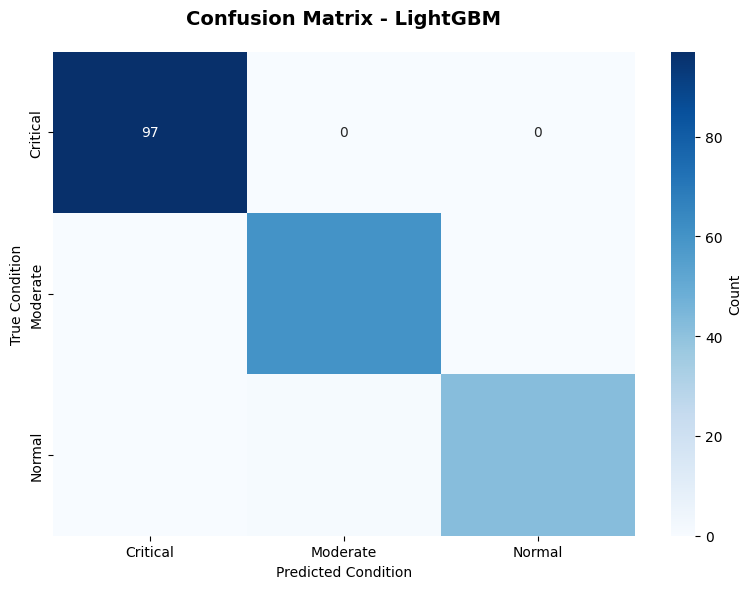


✅ Per-Class Accuracy:
   Critical: 1.0000 (100.00%)
   Moderate: 1.0000 (100.00%)
   Normal: 0.9767 (97.67%)


In [12]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - LightGBM', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Condition')
plt.ylabel('True Condition')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
print("\n✅ Per-Class Accuracy:")
for i, cls in enumerate(target_encoder.classes_):
    class_acc = cm[i, i] / cm[i, :].sum()
    print(f"   {cls}: {class_acc:.4f} ({class_acc*100:.2f}%)")

### 5.3 ROC-AUC Curves

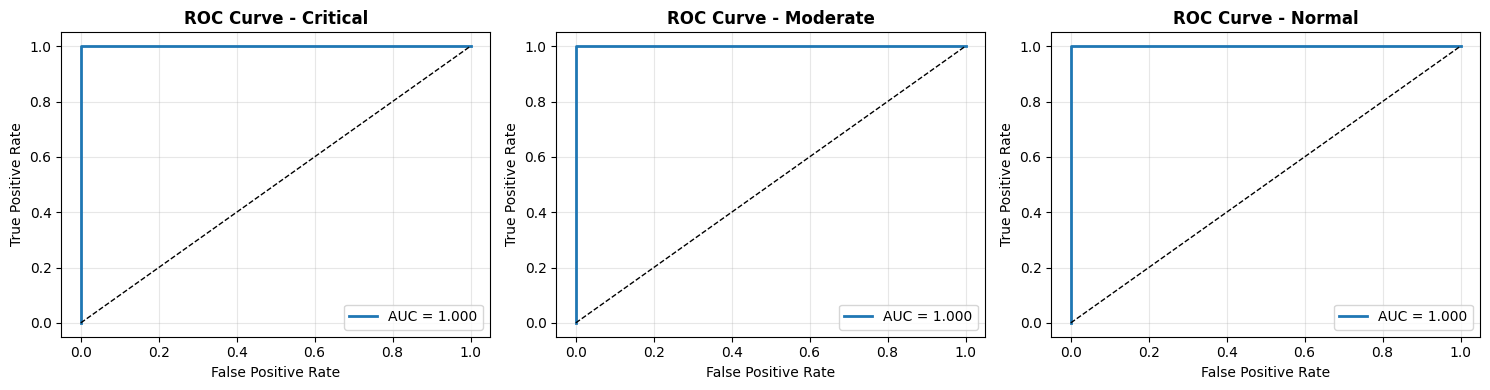


📊 Overall ROC-AUC (Macro): 1.0000


In [13]:
# Calculate ROC-AUC for each class (One-vs-Rest)
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=np.arange(len(target_encoder.classes_)))
n_classes = y_test_bin.shape[1]

# Plot ROC curves
fig, axes = plt.subplots(1, n_classes, figsize=(15, 4))
if n_classes == 1:
    axes = [axes]

for i, cls in enumerate(target_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])
    
    axes[i].plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', linewidth=2)
    axes[i].plot([0, 1], [0, 1], 'k--', linewidth=1)
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'ROC Curve - {cls}', fontweight='bold')
    axes[i].legend(loc='lower right')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Overall ROC-AUC
roc_auc_macro = roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovr')
print(f"\n📊 Overall ROC-AUC (Macro): {roc_auc_macro:.4f}")

## VI. Feature Importance Analysis

### 6.1 Built-in Feature Importance

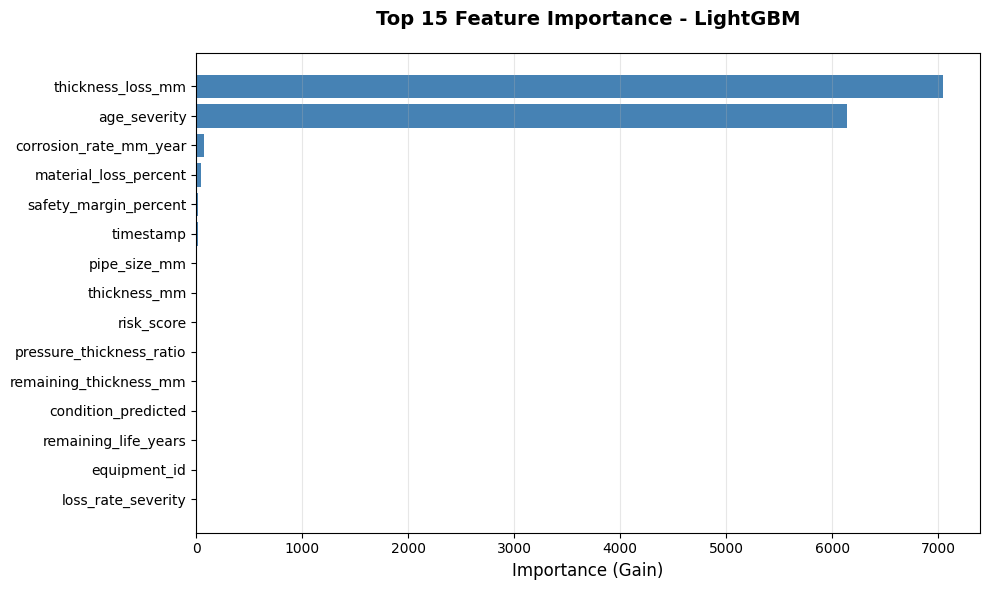


 Top 15 Most Important Features:


,feature,importance
8,thickness_loss_mm,7042.711171
24,age_severity,6136.512449
10,corrosion_rate_mm_year,74.010992
9,material_loss_percent,45.407338
13,safety_margin_percent,15.517450
1,timestamp,12.070187
4,pipe_size_mm,8.768230
5,thickness_mm,8.540538
16,risk_score,7.672197
14,pressure_thickness_ratio,5.473563


In [14]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

# Plot top 15 features
top_n = 15
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:top_n][::-1], 
         feature_importance['importance'][:top_n][::-1],
         color='steelblue')
plt.xlabel('Importance (Gain)', fontsize=12)
plt.title(f'Top {top_n} Feature Importance - LightGBM', fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n Top {top_n} Most Important Features:")
display(feature_importance.head(top_n))

### 6.2 SHAP Analysis

In [17]:
print("="*70)
print("                  SHAP FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Create SHAP explainer
print("\nComputing SHAP values (sampling 1000 records)...")
explainer = shap.TreeExplainer(lgb_model)

# Calculate SHAP values (use subset for speed)
sample_size = min(1000, len(X_test))
X_test_sample = X_test.iloc[:sample_size]
shap_values = explainer.shap_values(X_test_sample)

print(f"✅ SHAP values computed for {sample_size} samples")

                  SHAP FEATURE IMPORTANCE ANALYSIS

Computing SHAP values (sampling 1000 records)...
✅ SHAP values computed for 200 samples



               SHAP FEATURE IMPORTANCE ANALYSIS

Computing SHAP values for 200 samples...
Feature dimensions: (200, 25)
SHAP values type: <class 'numpy.ndarray'>
SHAP values is ndarray with shape: (200, 25, 3)

Debug: Features=25, SHAP shape=(25,)

Top 10 most important features (SHAP):
                     feature  importance
24              age_severity    1.423257
8          thickness_loss_mm    1.260631
13     safety_margin_percent    0.035512
9      material_loss_percent    0.032991
10    corrosion_rate_mm_year    0.022106
16                risk_score    0.007542
4               pipe_size_mm    0.006125
14  pressure_thickness_ratio    0.006031
5               thickness_mm    0.004845
1                  timestamp    0.004490
SHAP values type: <class 'numpy.ndarray'>
SHAP values is ndarray with shape: (200, 25, 3)

Debug: Features=25, SHAP shape=(25,)

Top 10 most important features (SHAP):
                     feature  importance
24              age_severity    1.423257
8         

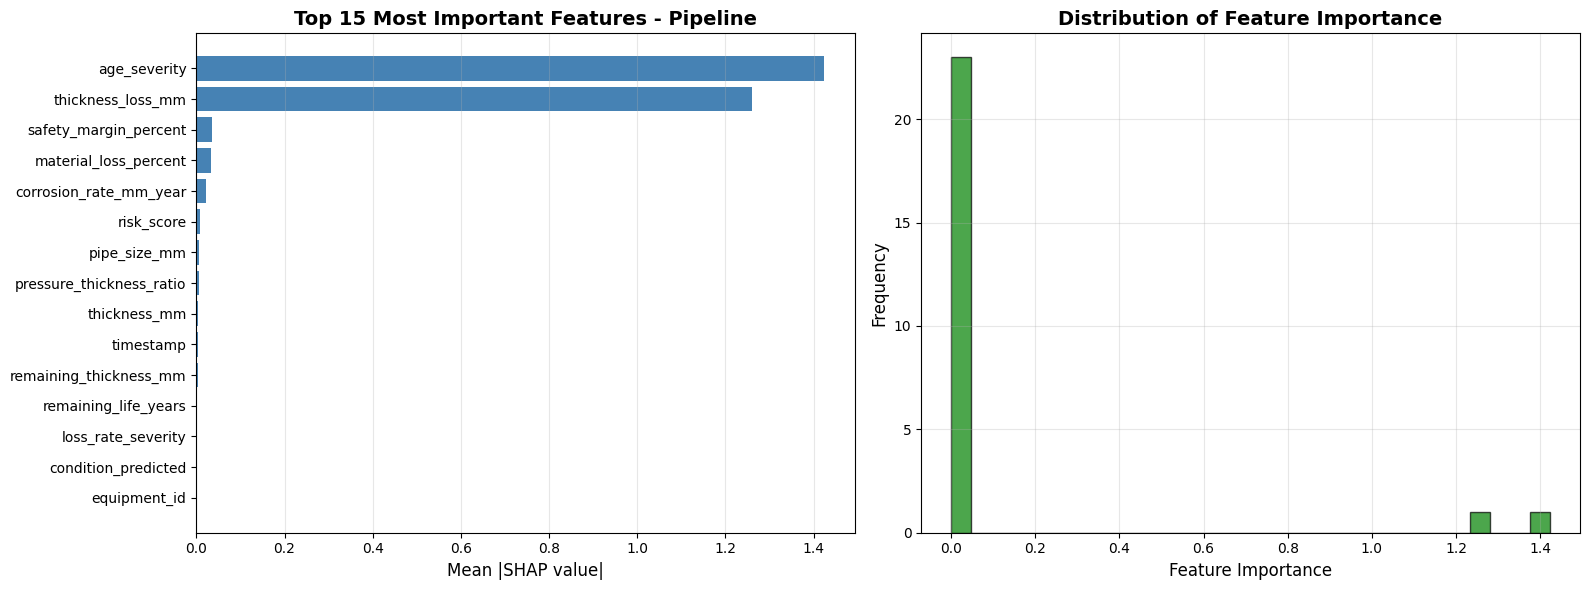


✅ SHAP plot saved to: d:\Final BA2\models\metrics\pipeline\pipeline_shap_importance.png
✅ SHAP importance saved to: d:\Final BA2\models\metrics\pipeline\pipeline_shap_importance.csv

KEY INSIGHTS:

1. Top 3 features for corrosion prediction:
   1. age_severity: 1.423
   2. thickness_loss_mm: 1.261
   3. safety_margin_percent: 0.036

2. Feature diversity: 5 features with importance > 0.01
   → LightGBM uses multiple features for prediction

3. Least important features: 12
   → Could be candidates for feature selection in future iterations


In [35]:
# SHAP Feature Importance for Pipeline Corrosion Classification
import shap

print("\n" + "="*70)
print(" "*15 + "SHAP FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Use a sample for SHAP computation
sample_size = min(1000, len(X_test))
X_test_sample = X_test.sample(n=sample_size, random_state=42)

print(f"\nComputing SHAP values for {sample_size} samples...")
print(f"Feature dimensions: {X_test_sample.shape}")

# Create TreeExplainer for LightGBM
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test_sample)

# For multiclass, shap_values is a list of arrays (one per class)
# Each array is shape (n_samples, n_features)
# We compute mean absolute SHAP across all samples and classes

print(f"SHAP values type: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"SHAP values is list with {len(shap_values)} classes")
    print(f"First class shape: {shap_values[0].shape}")
elif isinstance(shap_values, np.ndarray):
    print(f"SHAP values is ndarray with shape: {shap_values.shape}")

# Get mean absolute SHAP values per feature, averaged across classes
if isinstance(shap_values, list):
    # Multiclass case: for each class, get mean abs SHAP per feature
    # Then average across classes
    class_importances = []
    for sv in shap_values:
        # sv shape: (n_samples, n_features)
        # Take mean absolute value across samples, force to 1D
        class_imp = np.abs(sv).mean(axis=0).ravel()  # shape: (n_features,)
        class_importances.append(class_imp)
    
    # Stack and average importances across all classes
    # Use np.stack to create shape (n_classes, n_features), then average
    mean_shap = np.mean(np.stack(class_importances), axis=0)  # shape: (n_features,)
else:
    # Binary case or single 2D array for multiclass
    # For 3D array (n_samples, n_features, n_classes), need different handling
    if len(shap_values.shape) == 3:
        # Shape: (n_samples, n_features, n_classes)
        # Average across samples and classes
        mean_shap = np.abs(shap_values).mean(axis=(0, 2))  # shape: (n_features,)
    else:
        # Shape: (n_samples, n_features)
        mean_shap = np.abs(shap_values).mean(axis=0).ravel()

# Get feature names from X_test_sample
feature_names = X_test_sample.columns.tolist()

print(f"\nDebug: Features={len(feature_names)}, SHAP shape={mean_shap.shape}")

# Create feature importance dataframe  
shap_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_shap
}).sort_values('importance', ascending=False)

print("\nTop 10 most important features (SHAP):")
print(shap_importance.head(10))

# Plot top 15 features
top_n = min(15, len(shap_importance))
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
axes[0].barh(shap_importance['feature'][:top_n][::-1], 
             shap_importance['importance'][:top_n][::-1],
             color='steelblue')
axes[0].set_xlabel('Mean |SHAP value|', fontsize=12)
axes[0].set_title(f'Top {top_n} Most Important Features - Pipeline', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Distribution histogram
axes[1].hist(shap_importance['importance'], bins=30, color='green', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Feature Importance', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Feature Importance', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()

# Save SHAP plot
shap_plot_path = METRICS_DIR / 'pipeline_shap_importance.png'
plt.savefig(shap_plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ SHAP plot saved to: {shap_plot_path}")

# Save SHAP importance to CSV
shap_csv_path = METRICS_DIR / 'pipeline_shap_importance.csv'
shap_importance.to_csv(shap_csv_path, index=False)
print(f"✅ SHAP importance saved to: {shap_csv_path}")

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print(f"\n1. Top 3 features for corrosion prediction:")
for idx, (i, row) in enumerate(shap_importance.head(3).iterrows(), 1):
    print(f"   {idx}. {row['feature']}: {row['importance']:.3f}")

print(f"\n2. Feature diversity: {(shap_importance['importance'] > 0.01).sum()} features with importance > 0.01")
print("   → LightGBM uses multiple features for prediction")

print(f"\n3. Least important features: {(shap_importance['importance'] < 0.001).sum()}")
print("   → Could be candidates for feature selection in future iterations")

## VII. Forecasting & Predictions

### 7.1 Remaining Useful Life (RUL) Predictions

In [19]:
# Generate predictions for full dataset
full_pred_proba = lgb_model.predict(X, num_iteration=lgb_model.best_iteration)
full_pred = np.argmax(full_pred_proba, axis=1)
full_pred_labels = target_encoder.inverse_transform(full_pred)

# Create predictions dataframe
predictions_df = df_feat.copy()
predictions_df['predicted_condition'] = full_pred_labels
predictions_df['pred_critical_prob'] = full_pred_proba[:, 0]  # Probability of Critical
predictions_df['pred_moderate_prob'] = full_pred_proba[:, 1]  # Probability of Moderate
predictions_df['pred_normal_prob'] = full_pred_proba[:, 2]  # Probability of Normal

# Calculate confidence score (max probability)
predictions_df['confidence_score'] = np.max(full_pred_proba, axis=1)

# Maintenance priority (1=urgent, 2=soon, 3=scheduled, 4=routine)
def assign_priority(row):
    if row['predicted_condition'] == 'Critical':
        return 1 if row['remaining_life_years'] < 1 else 2
    elif row['predicted_condition'] == 'Moderate':
        return 2 if row['remaining_life_years'] < 3 else 3
    else:
        return 3 if row['remaining_life_years'] < 5 else 4

predictions_df['maintenance_priority'] = predictions_df.apply(assign_priority, axis=1)

print(" Predictions generated for all pipelines\n")
print(f" Prediction Summary:")
print(predictions_df['predicted_condition'].value_counts())
print(f"\n Maintenance Priority Distribution:")
priority_map = {1: 'Urgent', 2: 'Soon', 3: 'Scheduled', 4: 'Routine'}
for priority, count in predictions_df['maintenance_priority'].value_counts().sort_index().items():
    print(f"   {priority_map[priority]}: {count} ({count/len(predictions_df)*100:.1f}%)")

 Predictions generated for all pipelines

 Prediction Summary:
predicted_condition
Critical    487
Moderate    300
Normal      213
Name: count, dtype: int64

 Maintenance Priority Distribution:
   Urgent: 193 (19.3%)
   Soon: 378 (37.8%)
   Scheduled: 228 (22.8%)
   Routine: 201 (20.1%)


### 7.2 Critical Pipelines Report

In [20]:
# Identify critical pipelines requiring immediate attention
critical_pipelines = predictions_df[
    (predictions_df['predicted_condition'] == 'Critical') |
    (predictions_df['maintenance_priority'] == 1)
].sort_values(['maintenance_priority', 'remaining_life_years'])

print(" CRITICAL PIPELINES REQUIRING IMMEDIATE ATTENTION:\n")
print(f"   Total critical: {len(critical_pipelines)}")

if len(critical_pipelines) > 0:
    display_cols = [
        'pipeline_id', 'segment_id', 'predicted_condition', 'confidence_score',
        'remaining_life_years', 'risk_score', 'corrosion_rate_mm_year',
        'safety_margin_percent', 'maintenance_priority'
    ]
    available_display = [col for col in display_cols if col in critical_pipelines.columns]
    
    print("\n   Top 10 most critical:")
    display(critical_pipelines[available_display].head(10))
else:
    print("  No critical pipelines detected!")

 CRITICAL PIPELINES REQUIRING IMMEDIATE ATTENTION:

   Total critical: 487

   Top 10 most critical:


,predicted_condition,confidence_score,remaining_life_years,risk_score,corrosion_rate_mm_year,safety_margin_percent,maintenance_priority
10,Critical,0.997872,0.0,56.956,0.676403,23.611111,1
13,Critical,0.997879,0.0,66.368,0.470407,-17.919075,1
15,Critical,0.997915,0.0,89.932,0.333651,-16.833333,1
20,Critical,0.997886,0.0,74.320,0.402749,13.195691,1
21,Critical,0.997927,0.0,83.452,0.758242,-33.626761,1
27,Critical,0.997785,0.0,55.224,1.376559,18.942731,1
34,Critical,0.997870,0.0,86.728,8.821782,-95.824176,1
35,Critical,0.997870,0.0,97.124,9.435644,-135.308642,1
46,Critical,0.997870,0.0,117.844,3.825871,-113.611111,1
51,Critical,0.997915,0.0,79.640,0.370958,-3.104575,1


## VIII. Model & Predictions Export

### 8.1 Save Model

In [22]:
# Save LightGBM model
model_filename = MODEL_DIR / f"lgb_corrosion_model_{datetime.now().strftime('%Y%m%d')}.txt"
lgb_model.save_model(str(model_filename))
print(f" Model saved: {model_filename}")

# Save encoders and scaler
artifacts = {
    'target_encoder': target_encoder,
    'label_encoders': label_encoders,
    'scaler': scaler,
    'feature_names': X.columns.tolist()
}
artifacts_filename = MODEL_DIR / f"model_artifacts_{datetime.now().strftime('%Y%m%d')}.pkl"
joblib.dump(artifacts, artifacts_filename)
print(f" Artifacts saved: {artifacts_filename}")

 Model saved: d:\Final BA2\models\saved_models\pipeline\lgb_corrosion_model_20251118.txt
 Artifacts saved: d:\Final BA2\models\saved_models\pipeline\model_artifacts_20251118.pkl


### 8.2 Save Predictions

In [23]:
# Save full predictions
pred_filename = PRED_DIR / f"corrosion_predictions_{datetime.now().strftime('%Y%m%d')}.csv"
predictions_df.to_csv(pred_filename, index=False)
print(f" Predictions saved: {pred_filename}")

# Save critical pipelines report
critical_filename = PRED_DIR / f"critical_pipelines_{datetime.now().strftime('%Y%m%d')}.csv"
critical_pipelines.to_csv(critical_filename, index=False)
print(f" Critical report saved: {critical_filename}")

 Predictions saved: d:\Final BA2\predictions\corrosion_predictions_20251118.csv
 Critical report saved: d:\Final BA2\predictions\critical_pipelines_20251118.csv


## IX. Summary & Next Steps

In [24]:
print("="*70)
print(" "*20 + "MODELING SUMMARY")
print("="*70)

print("\n Model Performance:")
print(f"   Algorithm: LightGBM Gradient Boosting")
print(f"   Accuracy: {accuracy*100:.2f}%")
print(f"   F1-Score (Macro): {f1_macro:.4f}")
print(f"   ROC-AUC (Macro): {roc_auc_macro:.4f}")
print(f"   Best Iteration: {lgb_model.best_iteration}")

print("\n Feature Engineering:")
print(f"   Total features: {len(X.columns)}")
print(f"   Engineered features: corrosion_rate, remaining_life, risk_score, etc.")
print(f"   Top feature: {feature_importance.iloc[0]['feature']}")

print("\n Critical Insights:")
print(f"   Critical pipelines: {len(critical_pipelines)}")
print(f"   Urgent maintenance: {(predictions_df['maintenance_priority']==1).sum()}")
print(f"   Mean RUL: {predictions_df['remaining_life_years'].mean():.1f} years")

print("\n Outputs:")
print(f"   Model: {model_filename.name}")
print(f"   Predictions: {pred_filename.name}")
print(f"   Critical Report: {critical_filename.name}")

print("\n Next Steps:")
print("   1. Integrate predictions into dashboard (Streamlit/PowerBI)")
print("   2. Set up automated retraining pipeline")
print("   3. Implement real-time monitoring alerts")
print("   4. Validate predictions with domain experts")
print("   5. Deploy model as API endpoint (FastAPI/Flask)")

print("\n" + "="*70)
print(" MODELING COMPLETE")
print("="*70)

                    MODELING SUMMARY

 Model Performance:
   Algorithm: LightGBM Gradient Boosting
   Accuracy: 99.50%
   F1-Score (Macro): 0.9933
   ROC-AUC (Macro): 1.0000
   Best Iteration: 90

 Feature Engineering:
   Total features: 25
   Engineered features: corrosion_rate, remaining_life, risk_score, etc.
   Top feature: thickness_loss_mm

 Critical Insights:
   Critical pipelines: 487
   Urgent maintenance: 193
   Mean RUL: 62.6 years

 Outputs:
   Model: lgb_corrosion_model_20251118.txt
   Predictions: corrosion_predictions_20251118.csv
   Critical Report: critical_pipelines_20251118.csv

 Next Steps:
   1. Integrate predictions into dashboard (Streamlit/PowerBI)
   2. Set up automated retraining pipeline
   3. Implement real-time monitoring alerts
   4. Validate predictions with domain experts
   5. Deploy model as API endpoint (FastAPI/Flask)

 MODELING COMPLETE
